<a href="https://colab.research.google.com/github/sylv0303/Git/blob/main/Implied_Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [228]:
#!pip install yahoo_fin

In [99]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import sqrt
import yfinance as yf
from yahoo_fin import options as op
import pandas_datareader as pdr
from multiprocessing import Pool
import multiprocessing

# Implied Volatility
Implied volatility is a crucial indicator that measures anticipated fluctuations in the price of a financial asset. Unlike historical volatility, it is not based on past data, but rather uses real-time option prices to assess market expectations. This volatility is called "implied" because it is not directly observable and must be deduced from the current option price.

It is used as an indicator of investor sentiment regarding future price fluctuations. Implied volatility is often expressed as a percentage of expected price changes over a one-year period.

High implied volatility suggests that investors expect large price movements in the future, while low implied volatility indicates expectations of small price fluctuations.

To calculate implied volatility, we use the Black-Scholes model. These models take into account various factors such as the current price of the underlying asset, the option's strike price, the time remaining until the option expires and the risk-free interest rate. However, unlike the other variables, implied volatility is not directly observable; rather, it is adjusted in the pricing model until the option price calculated by the model matches the actual option price observed on the market.

In [177]:
# Define Black-Scholes formula
def black_scholes(S, K, T, r, sigma, option='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'call':
      return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
      return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [178]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
sigma = 0.2
option='call'
print(np.round(black_scholes(S, K, T, r, sigma), 3))

3.986


In [179]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
sigma = 0.2
print(np.round(black_scholes(S, K, T, r, sigma, option='call'), 3))

3.986


## Newton-Raphson Algorithm
We will calculate the implied volatility given the option prices calculated with the Black & Scholes model data.
For this, we will use Newton's method with root finding. We want to resolve:

$$
\text{Call}_{\text{BS}}(\sigma_{\text{implied}}) = P \iff f(x) = \text{Call}_{\text{BS}}(x) - P
$$


We use the 1st order Taylor expansion:

$$
x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}
$$

We fix a tolerance level and iterate the algorithm until the difference between the two consecutive estimations is below this level.

In [180]:
def newton_step(f, x0):
  def df(x):
    dx = 0.00001
    return (f(x + dx) - f(x)) / dx # derivation calculation (formula) --> gives an approximation
  return x0 - f(x0)/df(x0) # we use the approximation of this derivative to calculate x1

def newton(f, x0, tol):
    while abs(newton_step(f, x0) - x0) > tol: # iterates until the difference between approximation n+1 and n is below the tolerance threshold
        x0 = newton_step(f, x0)
    return x0


## Implied volatility estimation
$$ f(x) = \text{Call}_{\text{BS}}(x) - P $$

The function $f(x)$ is defined as $f(x) = \text{Call}_{\text{BS}}(x) - P$, where $ \text{Call}_{\text{BS}}(x) $ is the option price calculated with the Black-Scholes model as a function of volatility $x$ and $P$ is the observed market price of the option. When $f(x) = 0$, this means that the calculated option price is equal to the observed market price, giving us the implied volatility we're looking for.

So, in the Newton-Raphson algorithm, we iterate until we find a value for $x$.





In [181]:
#CallPrice(vol) - TargetPrice
CallPriceVol = lambda vol: black_scholes(S, K, T, r, vol, option='call') - C # to find when f(x) = 0 (intersection of abscissas) --> we find the root x (implicit flight) so f(x)= option price observed on the market

In [182]:
C = black_scholes(S, K, T, r, sigma, option='call')
init = 0.1  # we initialize x0
tol = 10**-8   # tolerance is restored (when you stop)
print(newton(CallPriceVol, init, tol)) # we run the algo and it sends us back the implicit flight

0.20000000003382454


In [183]:
# We test 4 iterations of the algo, we get x0, x1, x2, x3 and x4 (implicit theft).
x0 = init
for i in range(0,4):
  print(x0)
  x0 = newton_step(CallPriceVol, x0)

0.1
0.20777097726498
0.20000975370670124
0.20000000003382454


## Inflexion Point

We could use the 2nd order Taylor expansion to estimate the implied volaticity:

$$
f(x) = f(x_n) + f'(x_n)(x-x_n) + \frac{f''(\epsilon_n)}{2}(x-x_n)^2
$$

with

$$
x = x_{\text{target}} \quad \text{and} \quad f(x_{\text{target}}) = 0
$$

$$
x_{\text{target}} = x_n - \frac{f(x_n)}{f'(x_n)} - \frac{f''(x_n)}{2f'(x_n)}(x_{\text{target}} - x_n)^2
$$

One of the drawbacks of the Newton-Raphson Method is that convergence is not guaranteed.

We want to optimize the Newton-Raphson algorithm and to do this, we start the algorithm at an inflection point. Indeed, we know that at the inflection point, the second derivative is equal to zero because the curve is convex to the left and concave to the right. Therefore, our series σn is monotonous with:

$$
\sigma_0 > \sigma_1 > \sigma_2 > \ldots > \sigma_{\text{implied}}
$$

The algorithm is convergent and optimized.

The value of the inflection point is given by :

$$
I = \sqrt{\frac{2 \cdot |\log(m)|}{T}} \quad \text{and} \quad m = \frac{S}{K \cdot e^{-rT}} \quad \text{(moneyness)}
$$

In [184]:
def Inflexionpoint (S, K, T, r):
  m = S / (K * np.exp(-r * T))
  return np.sqrt(2 * np.abs(np.log(m)) / T)

In [185]:
I = Inflexionpoint(S, K, T, r)
print("Inflexion Point:", I)

Inflexion Point: 0.39390437504263387


## Implied Volatility with Inflexion Point

$$ f(x) = \text{Call}_{\text{BS}}(x) - P
$$
This equation can be solved with the Newton-Raphson algorithm, using the inflection point as the initial guess. The series σn is monotonous:

$$
\sigma_0 = I, \quad \sigma_{n+1} = \sigma_n - \frac{\text{Call}_{\text{BS}}(\sigma_n) - P}{\frac{\partial \text{Call}_{\text{BS}}(\sigma_n)}{\partial \sigma}}
$$

where Vega is:

$$
\frac{\partial \text{Call}_{\text{BS}}(\sigma_n)}{\partial \sigma} = S \cdot \sqrt{T} \cdot N'(d_1)
$$

In [186]:
def vega(S, sigma, K, T, r):
  d1 = (np.log(S / K) + (r  + 0.5 * sigma**2/2) * T) / (sigma * sqrt(T))
  vega = S * T**0.5 * norm.cdf(d1)
  return vega

def ImpliedVolCall(C, S, K, r, T, tol):
  x0 = Inflexionpoint(S, K, T, r)
  P = black_scholes(S, K, T, r, vol, option='call')
  v = vega(S, x0, K, T, r)
  while (abs((P - C) / v) > tol):
    x0 = x0 - (P - C) / v
    P = black_scholes(S, K, T, r, vol, option='call')
    v = vega(S, x0, K, T, r)
  return x0

In [ ]:
# Parameters
S = 100
K = 105
T = 0.5
r = 0.02
vol = 0.2

C = black_scholes(S, K, T, r, vol, option='call')

In [187]:
tol = 10**-8
ImpliedVolCall(C, S, K, r, T, tol)

0.39390437504263387

## 3) Import options data


In [213]:
# Check expiration dates
ticker = 'AMZN'
expiry = op.get_expiration_dates(ticker)
expiry

['February 23, 2024',
 'March 1, 2024',
 'March 8, 2024',
 'March 15, 2024',
 'March 22, 2024',
 'March 28, 2024',
 'April 19, 2024',
 'May 17, 2024',
 'June 21, 2024',
 'July 19, 2024',
 'August 16, 2024',
 'September 20, 2024',
 'October 18, 2024',
 'November 15, 2024',
 'December 20, 2024',
 'January 17, 2025',
 'March 21, 2025',
 'June 20, 2025',
 'September 19, 2025',
 'December 19, 2025',
 'January 16, 2026',
 'June 18, 2026']

In [221]:
# Set stock ticker and expiry date
ticker = 'AMZN'
expiry = '2024-04-19'

# Get stock data for the past year
start_date = pd.to_datetime('today') - pd.DateOffset(years=1)
end_date = pd.to_datetime('today')
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Calculate historical volatility
returns = stock_data['Adj Close'].pct_change().dropna()
volatility = returns.std() * np.sqrt(252)

# Get option chain for stock ticker and expiry date
option_chain = yf.Ticker(ticker).option_chain(expiry)

# Filter option chain for puts and calls
puts = option_chain.puts.sort_values(by='lastPrice')
calls = option_chain.calls.sort_values(by='lastPrice')

# Filter for conservative trader
conservative_puts = puts[(puts["inTheMoney"] == True)]
conservative_calls = calls[(calls["inTheMoney"] == True)]
"""
We could also exclude low-volume options because they are illiquid: OTM and ITM options are often less liquid than those close to the money (ATM)
treshold_volume = 500
conservative_puts = puts[(puts["inTheMoney"] == True) & (puts["volume"] >= treshold_volume)].head(5)
conservative_calls = calls[(calls["inTheMoney"] == True) & (calls["volume"] >= treshold_volume)].tail(5)
"""

[*********************100%%**********************]  1 of 1 completed


'\nWe could also exclude low-volume options because they are illiquid: OTM and ITM options are often less liquid than those close to the money (ATM)\ntreshold_volume = 500\nconservative_puts = puts[(puts["inTheMoney"] == True) & (puts["volume"] >= treshold_volume)].head(5)\nconservative_calls = calls[(calls["inTheMoney"] == True) & (calls["volume"] >= treshold_volume)].tail(5)\n'


We first fetch the options chain data for a specific stock from Yahoo Finance. Then, we compute historical volatility using data from the past year to improve our option approximations. Next, we add code to filter and select "conservative options," also known as "in-the-money" options, as a means of incorporating financial prudence into our analysis.
Now, we will integrate the Black-Scholes model, which calculates the theoretical price of an option, representing its fair value in an ideally efficient market.






In [222]:
# Estimate fair price for each option using Black-Scholes formula
market_price = yf.Ticker(ticker).fast_info['lastPrice']

# Set risk-free interest rate
risk_free_ticker = 'DGS1'
risk_free_rate = pdr.get_data_fred(risk_free_ticker)
r = risk_free_rate.iloc[-1]['DGS1']

# Calculate fair price with B&S model
conservative_puts['fair_price'] = black_scholes(
    market_price, conservative_puts['strike'],
    (pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365, r, volatility,
    option='put')

conservative_calls['fair_price'] = black_scholes(
    market_price, conservative_calls['strike'],
    (pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365, r, volatility,
    option='call')

# Calculate expected return for each option
conservative_calls['expected_return'] = (conservative_calls['fair_price'] - conservative_calls['lastPrice']) / conservative_calls['lastPrice']
conservative_puts['expected_return'] = (conservative_puts['fair_price'] - conservative_puts['lastPrice']) / conservative_puts['lastPrice']

# Rank options by expected return and suggest top 3 put and call
suggested_puts = conservative_puts.sort_values('expected_return', ascending=False).head(3)
suggested_calls = conservative_calls.sort_values('expected_return', ascending=False).head(3)

# Print suggested options and stock price
print("Suggested puts:")
print(suggested_puts[['strike', 'lastTradeDate', 'lastPrice', 'ask', 'volume', 'impliedVolatility', 'fair_price',
                      'expected_return']].to_string(index=False))
print("\nStock Price:")
print(f"The current price of {ticker} is ${market_price:.2f}")
print("\nSuggested calls:")
print(suggested_calls[['strike', 'lastTradeDate', 'lastPrice', 'ask', 'impliedVolatility', 'fair_price',
                       'expected_return']].to_string(index=False))

Suggested puts:
 strike             lastTradeDate  lastPrice   ask  volume  impliedVolatility  fair_price  expected_return
  230.0 2024-02-08 15:30:59+00:00       59.0 60.75       3           0.369147    0.000060        -0.999999
  220.0 2024-02-12 16:31:40+00:00       46.6 50.75      10           0.324714    0.000011        -1.000000
  215.0 2024-02-13 19:58:10+00:00       46.9 45.80      33           0.310310    0.000004        -1.000000

Stock Price:
The current price of AMZN is $169.51

Suggested calls:
 strike             lastTradeDate  lastPrice   ask  impliedVolatility  fair_price  expected_return
  165.0 2024-02-16 20:59:46+00:00      10.60 10.75           0.299568   97.122926         8.162540
  160.0 2024-02-16 20:59:46+00:00      14.00 14.15           0.314033   99.316474         6.094034
  155.0 2024-02-16 20:59:27+00:00      17.87 18.10           0.337165  101.510021         4.680471


<ipython-input-222-3b9afece69c1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conservative_puts['fair_price'] = black_scholes(
<ipython-input-222-3b9afece69c1>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conservative_calls['fair_price'] = black_scholes(
<ipython-input-222-3b9afece69c1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

The code now ranks options based on their expected return and presents them alongside the stock price. The output displays call and put options, their fair price, and expected return. Additionally, we can retrieve implied volatility data from yfinance. This output could resemble the option trading page of a brokerage account.

Next, we will add code to plot the options against the stock price over time.

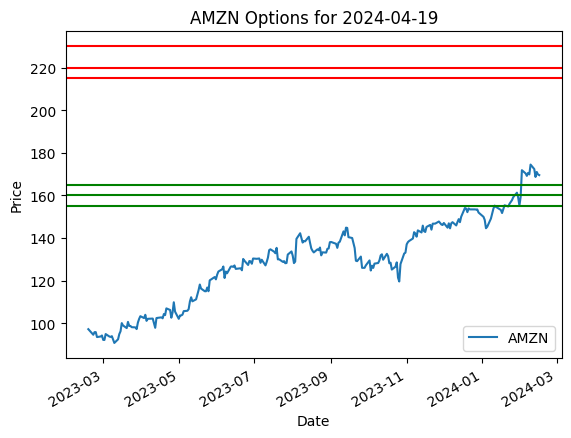

In [223]:
# Plot stock price and options
fig, ax = plt.subplots()

# Plot stock price
stock_data['Adj Close'].plot(ax=ax, label=ticker)

# Plot put options
for i, row in suggested_puts.iterrows():
    ax.axhline(y=row['strike'], color='r', linestyle='-')

# Plot call options
for i, row in suggested_calls.iterrows():
    ax.axhline(y=row['strike'], color='g', linestyle='-')

plt.legend()
plt.title(f'{ticker} Options for {expiry}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig("plot.png")

Opening the image plot.png in the same directory reveals a visually appealing representation of the option contracts, offering insights for technical analysis.

## 5) View the implied volatilities contained in the dataframe


# Smile volatility
When plotting implied volatility against the option's strike price, instead of observing a straight line as the Black-Scholes model would suggest, we typically see a smile-shaped curve. This curve indicates that implied volatility is generally higher for out-of-the-money and in-the-money options, and lower for at-the-money options.

The volatility smile shows that the market assigns a higher probability to large price movements (both up and down) than the Black-Scholes model predicts. It can be caused by several factors, such as supply and demand dynamics in the options market, fear of tail events (unexpected large price movements), and imperfections in the Black-Scholes model.






### 5.1) Call Option

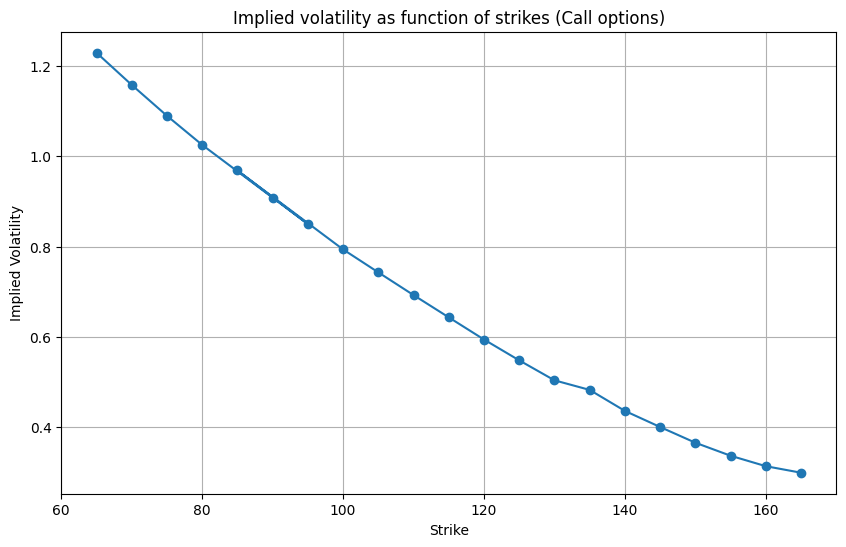

In [224]:
implied_volatility_call = conservative_calls["impliedVolatility"]
strike_call = conservative_calls["strike"]

plt.figure(figsize=(10, 6))
plt.plot(strike_call, implied_volatility_call, marker='o', linestyle='-')
plt.title("Implied volatility as function of strikes (Call options)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()


### 5.2) Put Option

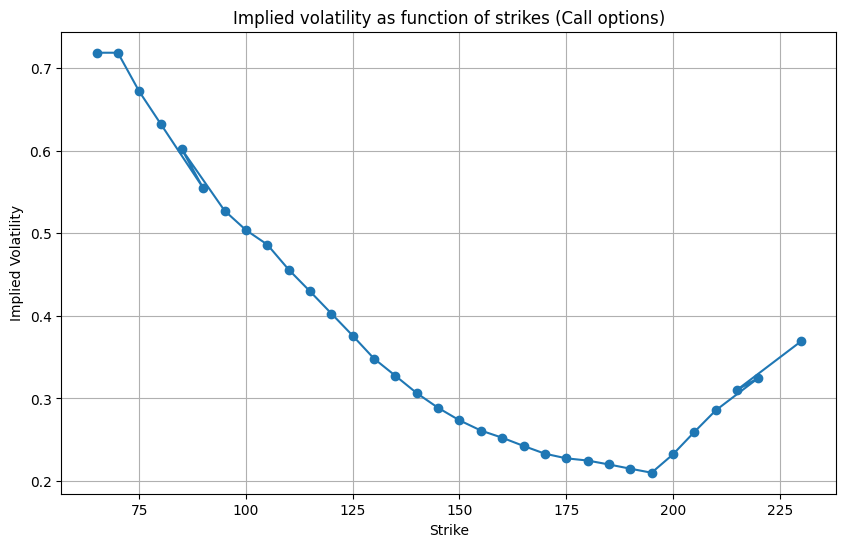

In [225]:
strike_put = puts["strike"]
implied_volatility_put = puts["impliedVolatility"]

plt.figure(figsize=(10,6))
plt.plot(strike_put, implied_volatility_put, marker='o', linestyle='-')
plt.title("Implied volatility as function of strikes (Call options)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.grid(True)
plt.show()

## 6) Calculate implied volatility with our functions

In [226]:
# import multiprocessing
# Check pool number
pool = multiprocessing.Pool()
pool

<multiprocessing.pool.Pool state=RUN pool_size=2>

In [227]:
def compute_implied_volatility(row):
    C = row['fair_price']  # Option price extraction
    K = row['strike']  # Extraction of strike price
    return ImpliedVolCall(C, S, K, r, T, tol)

# Multiprocessing
args_list = [row for index, row in conservative_calls.iterrows()] # Iteration on each line to extract C and K, storage in a list
with Pool() as pool:
    implied_volatilities = pool.map(compute_implied_volatility, args_list) # Parallelization of the function applied to each element of args_list, storage in list

# Parameters
S = market_price
T = (pd.to_datetime(expiry) - pd.to_datetime('today')).days / 365
r = risk_free_rate.iloc[-1]['DGS1']
tol = 10**-8


conservative_calls['implied_vol_calc'] = implied_volatilities
data = conservative_calls[["fair_price", "impliedVolatility", "implied_vol_calc"]]
data["implied_diff"] = data["implied_vol_calc"] - data["impliedVolatility"]
data.head()


<ipython-input-227-7bb07c347c22>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conservative_calls['implied_vol_calc'] = implied_volatilities
<ipython-input-227-7bb07c347c22>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["implied_diff"] = data["implied_vol_calc"] - data["impliedVolatility"]


,fair_price,impliedVolatility,implied_vol_calc,implied_diff
20,97.122926,0.299568,3.191036,2.891469
19,99.316474,0.314033,3.248225,2.934192
18,101.510021,0.337165,3.306192,2.969027
17,103.703569,0.365973,3.365013,2.999040
16,105.897117,0.400763,3.424765,3.024002


There is a difference between market implied volatility and calculated volatility. Market implied volatility is too low compared to calculated implied volatility. In this case, a trader can take a position by buying the option and make a profit if implied volatility rises. Conversely, if a trader believes that the implied volatility of an option is too high in relation to his own estimate of future volatility, he can sell the option and make a profit if implied volatility falls.

An increase in implied volatility will lead to an increase in the price of both call and put options.

This is because as volatility rises, the potential for price movement in the underlying asset is greater, increasing the likelihood that the option will end up in the money. Consequently, an option in a high-volatility environment will be more expensive than a similar option in a low-volatility environment.